In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

### Dataset

In [2]:
dataset = pd.read_csv('../../../data/zeda/Merged-update_hourly.csv', index_col=0)  # domain1 no revised dataset
# dataset = pd.read_csv('data/zeda/Merged-update_flowpos.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset[:]
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


### Dataset Information

In [3]:
print(list(data.columns))

['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN']


### Pre-processing

In [4]:
# specify the number of lag hours
n_hours = 24*7
K = 24

#### Stage

In [5]:
# Pre-processing
# Stage --> 8 stages
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)

stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96241, 768)


In [6]:
stages_supervised

,var1(t-168),var2(t-168),var3(t-168),var4(t-168),var1(t-167),var2(t-167),var3(t-167),var4(t-167),var1(t-166),var2(t-166),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/8/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,-0.22,-0.30,-0.60,-0.38,-0.41,-0.44,-0.42,-0.26,-0.24,-0.31
1/8/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,-0.41,-0.44,-0.42,-0.26,-0.24,-0.31,0.10,0.25,0.29,0.25
1/8/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,-0.24,-0.31,0.10,0.25,0.29,0.25,0.66,0.82,0.86,0.78
1/8/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,0.29,0.25,0.66,0.82,0.86,0.78,1.10,1.24,1.30,1.22
1/8/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,0.86,0.78,1.10,1.24,1.30,1.22,1.49,1.62,1.68,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.04,1.07,1.13,1.060,0.73,0.75,0.83,0.80,0.42,0.39,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,0.73,0.75,0.83,0.800,0.42,0.39,0.46,0.49,0.49,0.48,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.42,0.39,0.46,0.490,0.49,0.48,0.55,0.50,0.83,0.80,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


In [7]:
# stages_head = dataset[['HWS_S25A', 'HWS_S25B', 'HWS_S26']]
# print("stages_head.shape:", stages_head.shape)

# # stages_supervised = stage_series_to_supervised(stages, n_hours, K, 1)
# stages_head_supervised = series_to_supervised(stages_head, n_hours, K)
# print("stages_head_supervised.shape:", stages_head_supervised.shape)

In [8]:
# stages_head_supervised

#### Non-stage

In [9]:
# non_stages = data[['WS_S4', 'FLOW_S25A', 'GATE_S25A', 'FLOW_S25B', 'GATE_S25B', 'FLOW_S26', 'GATE_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
non_stages = data[['WS_S4', 'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 'PUMP_S26', 'PUMP_S25B', 'MEAN_RAIN']]
print("non_stages.shape:", non_stages.shape)

non_stages_supervised = series_to_supervised(non_stages, n_hours-1, 1)
print("non_stages_supervised.shape:", non_stages_supervised.shape)

non_stages.shape: (96432, 7)
non_stages_supervised.shape: (96265, 1176)


In [10]:
# non_stages_supervised

In [11]:
non_stages_supervised_cut = non_stages_supervised.iloc[24:, :]
print("non_stages_supervised_cut.shape:", non_stages_supervised_cut.shape)

non_stages_supervised_cut.shape: (96241, 1176)


In [12]:
# non_stages_supervised_cut

### N_out, N_in, K

In [13]:
# specify the number of lag hours
# n_hours = 72
n_features = stages.shape[1] + non_stages.shape[1]   # 1 rainfall + FGate_S25A + FGate_S25B + FGate_S26 + 8WS + PUMP_S26
# K = 12

In [14]:
n_features

11

### Concatenation

In [15]:
# stages_head_supervised.reset_index(drop=True, inplace=True)
non_stages_supervised_cut.reset_index(drop=True, inplace=True)
stages_supervised.reset_index(drop=True, inplace=True)

all_data = concat([
                   non_stages_supervised_cut.iloc[:, :],
#                    stages_head_supervised.iloc[:, :-3*K],
                   stages_supervised.iloc[:, :]],
                   axis=1)

In [16]:
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96241, 1944)


In [17]:
# all_concat = pd.DataFrame(all_data)
# all_concat

In [18]:
# all_concat.iloc[:, -12:]

### Train & Test set

In [19]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test = all_data[n_train_hours:, :]

n_train_hours: 76992


In [20]:
train.shape

(76992, 1944)

In [21]:
# test set (10/16/2018 - 12/30/3020)
# data.iloc[462368:, :]

### Normalization

In [22]:
n_hours

168

In [23]:
n_features

11

In [24]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -stages.shape[1]*K:]
test_X, test_y = test[:, :n_obs], test[:, -stages.shape[1]*K:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (76992, 1848) (76992, 96) (19249, 1848) (19249, 96)


In [25]:
n_obs

1848

In [26]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (76992, 168, 11) (76992, 96) (19249, 168, 11) (19249, 96)


### Model

- SimpleRNN(64), no dropout, activation=relu, 2000 epoch --> 0.0016

In [27]:
# Simple RNN Model
model_rnn_60 = keras.Sequential()

# model_rnn_60.add(layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])))
model_rnn_60.add(layers.SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model_rnn_60.add(layers.Dense(8, activation='relu'))
model_rnn_60.add(layers.Dense(train_y.shape[1]))   # Regression -> No Need for Activation
model_rnn_60.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               17920     
                                                                 
 dense (Dense)               (None, 96)                12384     
                                                                 
Total params: 30,304
Trainable params: 30,304
Non-trainable params: 0
_________________________________________________________________


2022-07-23 23:14:11.301476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/2000
151/151 - 13s - loss: 0.1735 - mae: 0.3673 - val_loss: 0.3027 - val_mae: 0.4883 - 13s/epoch - 85ms/step
Epoch 2/2000
151/151 - 12s - loss: 0.1543 - mae: 0.3455 - val_loss: 0.2725 - val_mae: 0.4610 - 12s/epoch - 78ms/step
Epoch 3/2000
151/151 - 12s - loss: 0.1377 - mae: 0.3231 - val_loss: 0.2404 - val_mae: 0.4260 - 12s/epoch - 78ms/step
Epoch 4/2000
151/151 - 12s - loss: 0.1150 - mae: 0.2868 - val_loss: 0.1847 - val_mae: 0.3562 - 12s/epoch - 77ms/step
Epoch 5/2000
151/151 - 12s - loss: 0.0826 - mae: 0.2303 - val_loss: 0.1222 - val_mae: 0.2748 - 12s/epoch - 78ms/step
Epoch 6/2000
151/151 - 12s - loss: 0.0550 - mae: 0.1843 - val_loss: 0.0784 - val_mae: 0.2196 - 12s/epoch - 81ms/step
Epoch 7/2000
151/151 - 12s - loss: 0.0362 - mae: 0.1509 - val_loss: 0.0534 - val_mae: 0.1830 - 12s/epoch - 79ms/step
Epoch 8/2000
151/151 - 12s - loss: 0.0259 - mae: 0.1291 - val_loss: 0.0398 - val_mae: 0.1602 - 12s/epoch - 79ms/step
Epoch 9/2000
151/151 - 13s - loss: 0.0201 - mae: 0.1153 - val_lo

Epoch 71/2000
151/151 - 12s - loss: 0.0012 - mae: 0.0262 - val_loss: 0.0031 - val_mae: 0.0442 - 12s/epoch - 78ms/step
Epoch 72/2000
151/151 - 12s - loss: 0.0012 - mae: 0.0262 - val_loss: 0.0031 - val_mae: 0.0441 - 12s/epoch - 78ms/step
Epoch 73/2000
151/151 - 12s - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0031 - val_mae: 0.0440 - 12s/epoch - 78ms/step
Epoch 74/2000
151/151 - 12s - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0031 - val_mae: 0.0439 - 12s/epoch - 78ms/step
Epoch 75/2000
151/151 - 12s - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0031 - val_mae: 0.0438 - 12s/epoch - 78ms/step
Epoch 76/2000
151/151 - 12s - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0031 - val_mae: 0.0438 - 12s/epoch - 78ms/step
Epoch 77/2000
151/151 - 12s - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0030 - val_mae: 0.0437 - 12s/epoch - 78ms/step
Epoch 78/2000
151/151 - 12s - loss: 0.0012 - mae: 0.0259 - val_loss: 0.0030 - val_mae: 0.0436 - 12s/epoch - 78ms/step
Epoch 79/2000
151/151 - 12s - loss: 0.0012 - mae: 0.0259

151/151 - 12s - loss: 0.0010 - mae: 0.0240 - val_loss: 0.0025 - val_mae: 0.0399 - 12s/epoch - 78ms/step
Epoch 141/2000
151/151 - 12s - loss: 0.0010 - mae: 0.0239 - val_loss: 0.0025 - val_mae: 0.0398 - 12s/epoch - 78ms/step
Epoch 142/2000
151/151 - 12s - loss: 0.0010 - mae: 0.0239 - val_loss: 0.0025 - val_mae: 0.0398 - 12s/epoch - 78ms/step
Epoch 143/2000
151/151 - 12s - loss: 0.0010 - mae: 0.0239 - val_loss: 0.0025 - val_mae: 0.0397 - 12s/epoch - 78ms/step
Epoch 144/2000
151/151 - 12s - loss: 0.0010 - mae: 0.0239 - val_loss: 0.0025 - val_mae: 0.0397 - 12s/epoch - 78ms/step
Epoch 145/2000
151/151 - 12s - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0025 - val_mae: 0.0396 - 12s/epoch - 78ms/step
Epoch 146/2000
151/151 - 12s - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0025 - val_mae: 0.0396 - 12s/epoch - 78ms/step
Epoch 147/2000
151/151 - 12s - loss: 0.0010 - mae: 0.0238 - val_loss: 0.0025 - val_mae: 0.0395 - 12s/epoch - 78ms/step
Epoch 148/2000
151/151 - 12s - loss: 0.0010 - mae: 0.0238 - val

Epoch 208/2000
151/151 - 12s - loss: 9.1277e-04 - mae: 0.0221 - val_loss: 0.0022 - val_mae: 0.0367 - 12s/epoch - 78ms/step
Epoch 209/2000
151/151 - 12s - loss: 9.1090e-04 - mae: 0.0221 - val_loss: 0.0022 - val_mae: 0.0367 - 12s/epoch - 78ms/step
Epoch 210/2000
151/151 - 12s - loss: 9.0903e-04 - mae: 0.0221 - val_loss: 0.0022 - val_mae: 0.0366 - 12s/epoch - 78ms/step
Epoch 211/2000
151/151 - 12s - loss: 9.0720e-04 - mae: 0.0220 - val_loss: 0.0022 - val_mae: 0.0366 - 12s/epoch - 79ms/step
Epoch 212/2000
151/151 - 12s - loss: 9.0537e-04 - mae: 0.0220 - val_loss: 0.0022 - val_mae: 0.0365 - 12s/epoch - 78ms/step
Epoch 213/2000
151/151 - 12s - loss: 9.0356e-04 - mae: 0.0220 - val_loss: 0.0022 - val_mae: 0.0365 - 12s/epoch - 78ms/step
Epoch 214/2000
151/151 - 12s - loss: 9.0176e-04 - mae: 0.0219 - val_loss: 0.0021 - val_mae: 0.0365 - 12s/epoch - 78ms/step
Epoch 215/2000
151/151 - 12s - loss: 8.9998e-04 - mae: 0.0219 - val_loss: 0.0021 - val_mae: 0.0364 - 12s/epoch - 78ms/step
Epoch 216/2000
1

Epoch 275/2000
151/151 - 12s - loss: 8.2351e-04 - mae: 0.0208 - val_loss: 0.0020 - val_mae: 0.0347 - 12s/epoch - 78ms/step
Epoch 276/2000
151/151 - 12s - loss: 8.2267e-04 - mae: 0.0207 - val_loss: 0.0020 - val_mae: 0.0346 - 12s/epoch - 78ms/step
Epoch 277/2000
151/151 - 12s - loss: 8.2184e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0346 - 12s/epoch - 78ms/step
Epoch 278/2000
151/151 - 12s - loss: 8.2101e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0346 - 12s/epoch - 78ms/step
Epoch 279/2000
151/151 - 12s - loss: 8.2019e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0346 - 12s/epoch - 78ms/step
Epoch 280/2000
151/151 - 12s - loss: 8.1939e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0346 - 12s/epoch - 78ms/step
Epoch 281/2000
151/151 - 12s - loss: 8.1859e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0345 - 12s/epoch - 78ms/step
Epoch 282/2000
151/151 - 12s - loss: 8.1781e-04 - mae: 0.0207 - val_loss: 0.0019 - val_mae: 0.0345 - 12s/epoch - 78ms/step
Epoch 283/2000
1

Epoch 342/2000
151/151 - 12s - loss: 7.8227e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0335 - 12s/epoch - 78ms/step
Epoch 343/2000
151/151 - 12s - loss: 7.8179e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0335 - 12s/epoch - 78ms/step
Epoch 344/2000
151/151 - 12s - loss: 7.8132e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0335 - 12s/epoch - 78ms/step
Epoch 345/2000
151/151 - 12s - loss: 7.8085e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0335 - 12s/epoch - 78ms/step
Epoch 346/2000
151/151 - 12s - loss: 7.8038e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0334 - 12s/epoch - 79ms/step
Epoch 347/2000
151/151 - 12s - loss: 7.7992e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0334 - 12s/epoch - 78ms/step
Epoch 348/2000
151/151 - 12s - loss: 7.7945e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0334 - 12s/epoch - 78ms/step
Epoch 349/2000
151/151 - 12s - loss: 7.7899e-04 - mae: 0.0201 - val_loss: 0.0018 - val_mae: 0.0334 - 12s/epoch - 78ms/step
Epoch 350/2000
1

Epoch 409/2000
151/151 - 12s - loss: 7.5519e-04 - mae: 0.0198 - val_loss: 0.0018 - val_mae: 0.0328 - 12s/epoch - 78ms/step
Epoch 410/2000
151/151 - 12s - loss: 7.5483e-04 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0328 - 12s/epoch - 78ms/step
Epoch 411/2000
151/151 - 12s - loss: 7.5450e-04 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0328 - 12s/epoch - 79ms/step
Epoch 412/2000
151/151 - 12s - loss: 7.5415e-04 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0328 - 12s/epoch - 78ms/step
Epoch 413/2000
151/151 - 12s - loss: 7.5381e-04 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0328 - 12s/epoch - 78ms/step
Epoch 414/2000
151/151 - 12s - loss: 7.5346e-04 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0328 - 12s/epoch - 78ms/step
Epoch 415/2000
151/151 - 12s - loss: 7.5312e-04 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0328 - 12s/epoch - 78ms/step
Epoch 416/2000
151/151 - 12s - loss: 7.5278e-04 - mae: 0.0197 - val_loss: 0.0018 - val_mae: 0.0328 - 12s/epoch - 78ms/step
Epoch 417/2000
1

Epoch 476/2000
151/151 - 12s - loss: 7.3439e-04 - mae: 0.0195 - val_loss: 0.0017 - val_mae: 0.0324 - 12s/epoch - 79ms/step
Epoch 477/2000
151/151 - 12s - loss: 7.3411e-04 - mae: 0.0195 - val_loss: 0.0017 - val_mae: 0.0324 - 12s/epoch - 78ms/step
Epoch 478/2000
151/151 - 12s - loss: 7.3383e-04 - mae: 0.0195 - val_loss: 0.0017 - val_mae: 0.0324 - 12s/epoch - 79ms/step
Epoch 479/2000
151/151 - 12s - loss: 7.3355e-04 - mae: 0.0195 - val_loss: 0.0017 - val_mae: 0.0324 - 12s/epoch - 78ms/step
Epoch 480/2000
151/151 - 12s - loss: 7.3326e-04 - mae: 0.0194 - val_loss: 0.0017 - val_mae: 0.0324 - 12s/epoch - 78ms/step
Epoch 481/2000
151/151 - 12s - loss: 7.3298e-04 - mae: 0.0194 - val_loss: 0.0017 - val_mae: 0.0324 - 12s/epoch - 78ms/step
Epoch 482/2000
151/151 - 12s - loss: 7.3270e-04 - mae: 0.0194 - val_loss: 0.0017 - val_mae: 0.0324 - 12s/epoch - 78ms/step
Epoch 483/2000
151/151 - 12s - loss: 7.3242e-04 - mae: 0.0194 - val_loss: 0.0017 - val_mae: 0.0323 - 12s/epoch - 79ms/step
Epoch 484/2000
1

Epoch 543/2000
151/151 - 12s - loss: 7.1645e-04 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0321 - 12s/epoch - 78ms/step
Epoch 544/2000
151/151 - 12s - loss: 7.1619e-04 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0321 - 12s/epoch - 78ms/step
Epoch 545/2000
151/151 - 12s - loss: 7.1593e-04 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0321 - 12s/epoch - 78ms/step
Epoch 546/2000
151/151 - 12s - loss: 7.1567e-04 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0321 - 12s/epoch - 78ms/step
Epoch 547/2000
151/151 - 12s - loss: 7.1541e-04 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0321 - 12s/epoch - 79ms/step
Epoch 548/2000
151/151 - 12s - loss: 7.1516e-04 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0321 - 12s/epoch - 78ms/step
Epoch 549/2000
151/151 - 12s - loss: 7.1490e-04 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0321 - 12s/epoch - 78ms/step
Epoch 550/2000
151/151 - 12s - loss: 7.1464e-04 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0321 - 12s/epoch - 79ms/step
Epoch 551/2000
1

Epoch 610/2000
151/151 - 12s - loss: 6.9929e-04 - mae: 0.0190 - val_loss: 0.0017 - val_mae: 0.0318 - 12s/epoch - 79ms/step
Epoch 611/2000
151/151 - 12s - loss: 6.9903e-04 - mae: 0.0190 - val_loss: 0.0017 - val_mae: 0.0318 - 12s/epoch - 79ms/step
Epoch 612/2000
151/151 - 12s - loss: 6.9878e-04 - mae: 0.0190 - val_loss: 0.0017 - val_mae: 0.0318 - 12s/epoch - 78ms/step
Epoch 613/2000
151/151 - 12s - loss: 6.9853e-04 - mae: 0.0190 - val_loss: 0.0017 - val_mae: 0.0318 - 12s/epoch - 79ms/step
Epoch 614/2000
151/151 - 12s - loss: 6.9827e-04 - mae: 0.0190 - val_loss: 0.0017 - val_mae: 0.0318 - 12s/epoch - 79ms/step
Epoch 615/2000
151/151 - 12s - loss: 6.9802e-04 - mae: 0.0190 - val_loss: 0.0017 - val_mae: 0.0318 - 12s/epoch - 79ms/step
Epoch 616/2000
151/151 - 12s - loss: 6.9777e-04 - mae: 0.0190 - val_loss: 0.0017 - val_mae: 0.0318 - 12s/epoch - 78ms/step
Epoch 617/2000
151/151 - 12s - loss: 6.9751e-04 - mae: 0.0190 - val_loss: 0.0017 - val_mae: 0.0318 - 12s/epoch - 78ms/step
Epoch 618/2000
1

Epoch 677/2000
151/151 - 12s - loss: 6.8267e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0316 - 12s/epoch - 78ms/step
Epoch 678/2000
151/151 - 12s - loss: 6.8243e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0316 - 12s/epoch - 79ms/step
Epoch 679/2000
151/151 - 12s - loss: 6.8218e-04 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0316 - 12s/epoch - 78ms/step
Epoch 680/2000
151/151 - 12s - loss: 6.8194e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0316 - 12s/epoch - 79ms/step
Epoch 681/2000
151/151 - 12s - loss: 6.8170e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0316 - 12s/epoch - 79ms/step
Epoch 682/2000
151/151 - 12s - loss: 6.8146e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0316 - 12s/epoch - 78ms/step
Epoch 683/2000
151/151 - 12s - loss: 6.8121e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0316 - 12s/epoch - 79ms/step
Epoch 684/2000
151/151 - 12s - loss: 6.8097e-04 - mae: 0.0187 - val_loss: 0.0016 - val_mae: 0.0316 - 12s/epoch - 78ms/step
Epoch 685/2000
1

Epoch 744/2000
151/151 - 12s - loss: 6.6597e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0314 - 12s/epoch - 78ms/step
Epoch 745/2000
151/151 - 12s - loss: 6.6571e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0314 - 12s/epoch - 78ms/step
Epoch 746/2000
151/151 - 12s - loss: 6.6545e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0314 - 12s/epoch - 78ms/step
Epoch 747/2000
151/151 - 12s - loss: 6.6519e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0314 - 12s/epoch - 78ms/step
Epoch 748/2000
151/151 - 12s - loss: 6.6492e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0314 - 12s/epoch - 78ms/step
Epoch 749/2000
151/151 - 12s - loss: 6.6467e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0314 - 12s/epoch - 78ms/step
Epoch 750/2000
151/151 - 12s - loss: 6.6441e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0314 - 12s/epoch - 78ms/step
Epoch 751/2000
151/151 - 12s - loss: 6.6414e-04 - mae: 0.0185 - val_loss: 0.0016 - val_mae: 0.0314 - 12s/epoch - 78ms/step
Epoch 752/2000
1

Epoch 811/2000
151/151 - 12s - loss: 6.4839e-04 - mae: 0.0183 - val_loss: 0.0016 - val_mae: 0.0312 - 12s/epoch - 78ms/step
Epoch 812/2000
151/151 - 12s - loss: 6.4811e-04 - mae: 0.0183 - val_loss: 0.0016 - val_mae: 0.0312 - 12s/epoch - 78ms/step
Epoch 813/2000
151/151 - 12s - loss: 6.4782e-04 - mae: 0.0183 - val_loss: 0.0016 - val_mae: 0.0312 - 12s/epoch - 78ms/step
Epoch 814/2000
151/151 - 12s - loss: 6.4754e-04 - mae: 0.0183 - val_loss: 0.0016 - val_mae: 0.0312 - 12s/epoch - 79ms/step
Epoch 815/2000
151/151 - 12s - loss: 6.4725e-04 - mae: 0.0183 - val_loss: 0.0016 - val_mae: 0.0312 - 12s/epoch - 79ms/step
Epoch 816/2000
151/151 - 12s - loss: 6.4697e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0312 - 12s/epoch - 78ms/step
Epoch 817/2000
151/151 - 12s - loss: 6.4669e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0312 - 12s/epoch - 78ms/step
Epoch 818/2000
151/151 - 12s - loss: 6.4640e-04 - mae: 0.0182 - val_loss: 0.0016 - val_mae: 0.0312 - 12s/epoch - 78ms/step
Epoch 819/2000
1

Epoch 878/2000
151/151 - 12s - loss: 6.2827e-04 - mae: 0.0180 - val_loss: 0.0016 - val_mae: 0.0309 - 12s/epoch - 78ms/step
Epoch 879/2000
151/151 - 12s - loss: 6.2795e-04 - mae: 0.0179 - val_loss: 0.0016 - val_mae: 0.0308 - 12s/epoch - 78ms/step
Epoch 880/2000
151/151 - 12s - loss: 6.2762e-04 - mae: 0.0179 - val_loss: 0.0016 - val_mae: 0.0308 - 12s/epoch - 79ms/step
Epoch 881/2000
151/151 - 12s - loss: 6.2729e-04 - mae: 0.0179 - val_loss: 0.0016 - val_mae: 0.0309 - 12s/epoch - 78ms/step
Epoch 882/2000
151/151 - 12s - loss: 6.2699e-04 - mae: 0.0179 - val_loss: 0.0016 - val_mae: 0.0308 - 12s/epoch - 79ms/step
Epoch 883/2000
151/151 - 12s - loss: 6.2666e-04 - mae: 0.0179 - val_loss: 0.0016 - val_mae: 0.0308 - 12s/epoch - 79ms/step
Epoch 884/2000
151/151 - 12s - loss: 6.2634e-04 - mae: 0.0179 - val_loss: 0.0016 - val_mae: 0.0308 - 12s/epoch - 78ms/step
Epoch 885/2000
151/151 - 12s - loss: 6.2600e-04 - mae: 0.0179 - val_loss: 0.0016 - val_mae: 0.0308 - 12s/epoch - 78ms/step
Epoch 886/2000
1

Epoch 945/2000
151/151 - 12s - loss: 6.0282e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0302 - 12s/epoch - 78ms/step
Epoch 946/2000
151/151 - 12s - loss: 6.0237e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0302 - 12s/epoch - 78ms/step
Epoch 947/2000
151/151 - 12s - loss: 6.0192e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0302 - 12s/epoch - 79ms/step
Epoch 948/2000
151/151 - 12s - loss: 6.0147e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0301 - 12s/epoch - 78ms/step
Epoch 949/2000
151/151 - 12s - loss: 6.0099e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0301 - 12s/epoch - 79ms/step
Epoch 950/2000
151/151 - 12s - loss: 6.0055e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0301 - 12s/epoch - 78ms/step
Epoch 951/2000
151/151 - 12s - loss: 6.0009e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0301 - 12s/epoch - 78ms/step
Epoch 952/2000
151/151 - 12s - loss: 5.9963e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0301 - 12s/epoch - 78ms/step
Epoch 953/2000
1

Epoch 1012/2000
151/151 - 12s - loss: 5.6573e-04 - mae: 0.0169 - val_loss: 0.0014 - val_mae: 0.0287 - 12s/epoch - 79ms/step
Epoch 1013/2000
151/151 - 12s - loss: 5.6509e-04 - mae: 0.0169 - val_loss: 0.0014 - val_mae: 0.0287 - 12s/epoch - 78ms/step
Epoch 1014/2000
151/151 - 12s - loss: 5.6442e-04 - mae: 0.0169 - val_loss: 0.0014 - val_mae: 0.0287 - 12s/epoch - 79ms/step
Epoch 1015/2000
151/151 - 12s - loss: 5.6377e-04 - mae: 0.0169 - val_loss: 0.0014 - val_mae: 0.0287 - 12s/epoch - 79ms/step
Epoch 1016/2000
151/151 - 12s - loss: 5.6312e-04 - mae: 0.0168 - val_loss: 0.0014 - val_mae: 0.0286 - 12s/epoch - 78ms/step
Epoch 1017/2000
151/151 - 12s - loss: 5.6247e-04 - mae: 0.0168 - val_loss: 0.0014 - val_mae: 0.0286 - 12s/epoch - 79ms/step
Epoch 1018/2000
151/151 - 12s - loss: 5.6183e-04 - mae: 0.0168 - val_loss: 0.0014 - val_mae: 0.0286 - 12s/epoch - 78ms/step
Epoch 1019/2000
151/151 - 12s - loss: 5.6118e-04 - mae: 0.0168 - val_loss: 0.0014 - val_mae: 0.0286 - 12s/epoch - 78ms/step
Epoch 10

151/151 - 12s - loss: 5.2540e-04 - mae: 0.0162 - val_loss: 0.0013 - val_mae: 0.0274 - 12s/epoch - 78ms/step
Epoch 1079/2000
151/151 - 12s - loss: 5.2485e-04 - mae: 0.0162 - val_loss: 0.0013 - val_mae: 0.0274 - 12s/epoch - 79ms/step
Epoch 1080/2000
151/151 - 12s - loss: 5.2433e-04 - mae: 0.0162 - val_loss: 0.0013 - val_mae: 0.0274 - 12s/epoch - 79ms/step
Epoch 1081/2000
151/151 - 12s - loss: 5.2381e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0274 - 12s/epoch - 78ms/step
Epoch 1082/2000
151/151 - 12s - loss: 5.2326e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0274 - 12s/epoch - 79ms/step
Epoch 1083/2000
151/151 - 12s - loss: 5.2274e-04 - mae: 0.0161 - val_loss: 0.0013 - val_mae: 0.0274 - 12s/epoch - 78ms/step
Epoch 1084/2000
151/151 - 12s - loss: 5.2221e-04 - mae: 0.0161 - val_loss: 0.0012 - val_mae: 0.0274 - 12s/epoch - 79ms/step
Epoch 1085/2000
151/151 - 12s - loss: 5.2170e-04 - mae: 0.0161 - val_loss: 0.0012 - val_mae: 0.0274 - 12s/epoch - 78ms/step
Epoch 1086/2000
151/151 

Epoch 1145/2000
151/151 - 12s - loss: 4.9400e-04 - mae: 0.0156 - val_loss: 0.0012 - val_mae: 0.0266 - 12s/epoch - 78ms/step
Epoch 1146/2000
151/151 - 12s - loss: 4.9361e-04 - mae: 0.0156 - val_loss: 0.0012 - val_mae: 0.0265 - 12s/epoch - 79ms/step
Epoch 1147/2000
151/151 - 12s - loss: 4.9321e-04 - mae: 0.0156 - val_loss: 0.0012 - val_mae: 0.0265 - 12s/epoch - 79ms/step
Epoch 1148/2000
151/151 - 12s - loss: 4.9283e-04 - mae: 0.0156 - val_loss: 0.0012 - val_mae: 0.0265 - 12s/epoch - 78ms/step
Epoch 1149/2000
151/151 - 12s - loss: 4.9244e-04 - mae: 0.0156 - val_loss: 0.0012 - val_mae: 0.0265 - 12s/epoch - 79ms/step
Epoch 1150/2000
151/151 - 12s - loss: 4.9205e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0265 - 12s/epoch - 79ms/step
Epoch 1151/2000
151/151 - 12s - loss: 4.9164e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0265 - 12s/epoch - 79ms/step
Epoch 1152/2000
151/151 - 12s - loss: 4.9125e-04 - mae: 0.0155 - val_loss: 0.0012 - val_mae: 0.0265 - 12s/epoch - 79ms/step
Epoch 11

151/151 - 12s - loss: 4.7014e-04 - mae: 0.0151 - val_loss: 0.0011 - val_mae: 0.0259 - 12s/epoch - 79ms/step
Epoch 1212/2000
151/151 - 12s - loss: 4.6981e-04 - mae: 0.0151 - val_loss: 0.0011 - val_mae: 0.0259 - 12s/epoch - 78ms/step
Epoch 1213/2000
151/151 - 12s - loss: 4.6948e-04 - mae: 0.0151 - val_loss: 0.0011 - val_mae: 0.0259 - 12s/epoch - 78ms/step
Epoch 1214/2000
151/151 - 12s - loss: 4.6914e-04 - mae: 0.0151 - val_loss: 0.0011 - val_mae: 0.0259 - 12s/epoch - 79ms/step
Epoch 1215/2000
151/151 - 12s - loss: 4.6882e-04 - mae: 0.0151 - val_loss: 0.0011 - val_mae: 0.0259 - 12s/epoch - 78ms/step
Epoch 1216/2000
151/151 - 12s - loss: 4.6851e-04 - mae: 0.0151 - val_loss: 0.0011 - val_mae: 0.0259 - 12s/epoch - 78ms/step
Epoch 1217/2000
151/151 - 12s - loss: 4.6820e-04 - mae: 0.0151 - val_loss: 0.0011 - val_mae: 0.0259 - 12s/epoch - 79ms/step
Epoch 1218/2000
151/151 - 12s - loss: 4.6788e-04 - mae: 0.0151 - val_loss: 0.0011 - val_mae: 0.0259 - 12s/epoch - 79ms/step
Epoch 1219/2000
151/151 

Epoch 1278/2000
151/151 - 12s - loss: 4.5025e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0254 - 12s/epoch - 78ms/step
Epoch 1279/2000
151/151 - 12s - loss: 4.5000e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0254 - 12s/epoch - 79ms/step
Epoch 1280/2000
151/151 - 12s - loss: 4.4973e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0254 - 12s/epoch - 79ms/step
Epoch 1281/2000
151/151 - 12s - loss: 4.4946e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0254 - 12s/epoch - 79ms/step
Epoch 1282/2000
151/151 - 12s - loss: 4.4918e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0254 - 12s/epoch - 78ms/step
Epoch 1283/2000
151/151 - 12s - loss: 4.4891e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0254 - 12s/epoch - 78ms/step
Epoch 1284/2000
151/151 - 12s - loss: 4.4863e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0254 - 12s/epoch - 78ms/step
Epoch 1285/2000
151/151 - 12s - loss: 4.4836e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0254 - 12s/epoch - 79ms/step
Epoch 12

151/151 - 12s - loss: 4.3337e-04 - mae: 0.0144 - val_loss: 0.0010 - val_mae: 0.0250 - 12s/epoch - 79ms/step
Epoch 1345/2000
151/151 - 12s - loss: 4.3312e-04 - mae: 0.0144 - val_loss: 0.0010 - val_mae: 0.0250 - 12s/epoch - 79ms/step
Epoch 1346/2000
151/151 - 12s - loss: 4.3287e-04 - mae: 0.0144 - val_loss: 0.0010 - val_mae: 0.0250 - 12s/epoch - 79ms/step
Epoch 1347/2000
151/151 - 12s - loss: 4.3263e-04 - mae: 0.0144 - val_loss: 0.0010 - val_mae: 0.0250 - 12s/epoch - 79ms/step
Epoch 1348/2000
151/151 - 12s - loss: 4.3239e-04 - mae: 0.0144 - val_loss: 0.0010 - val_mae: 0.0250 - 12s/epoch - 78ms/step
Epoch 1349/2000
151/151 - 12s - loss: 4.3216e-04 - mae: 0.0144 - val_loss: 0.0010 - val_mae: 0.0250 - 12s/epoch - 78ms/step
Epoch 1350/2000
151/151 - 12s - loss: 4.3192e-04 - mae: 0.0144 - val_loss: 0.0010 - val_mae: 0.0250 - 12s/epoch - 78ms/step
Epoch 1351/2000
151/151 - 12s - loss: 4.3169e-04 - mae: 0.0144 - val_loss: 0.0010 - val_mae: 0.0250 - 12s/epoch - 78ms/step
Epoch 1352/2000
151/151 

Epoch 1411/2000
151/151 - 12s - loss: 4.1775e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0246 - 12s/epoch - 78ms/step
Epoch 1412/2000
151/151 - 12s - loss: 4.1752e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0246 - 12s/epoch - 78ms/step
Epoch 1413/2000
151/151 - 12s - loss: 4.1729e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0246 - 12s/epoch - 79ms/step
Epoch 1414/2000
151/151 - 12s - loss: 4.1705e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0246 - 12s/epoch - 79ms/step
Epoch 1415/2000
151/151 - 12s - loss: 4.1682e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0246 - 12s/epoch - 78ms/step
Epoch 1416/2000
151/151 - 12s - loss: 4.1659e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0246 - 12s/epoch - 78ms/step
Epoch 1417/2000
151/151 - 12s - loss: 4.1636e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0246 - 12s/epoch - 78ms/step
Epoch 1418/2000
151/151 - 12s - loss: 4.1614e-04 - mae: 0.0141 - val_loss: 0.0010 - val_mae: 0.0246 - 12s/epoch - 78ms/step
Epoch 14

151/151 - 12s - loss: 4.0387e-04 - mae: 0.0138 - val_loss: 9.8570e-04 - val_mae: 0.0242 - 12s/epoch - 78ms/step
Epoch 1477/2000
151/151 - 12s - loss: 4.0365e-04 - mae: 0.0138 - val_loss: 9.8582e-04 - val_mae: 0.0242 - 12s/epoch - 79ms/step
Epoch 1478/2000
151/151 - 12s - loss: 4.0344e-04 - mae: 0.0138 - val_loss: 9.8555e-04 - val_mae: 0.0242 - 12s/epoch - 78ms/step
Epoch 1479/2000
151/151 - 12s - loss: 4.0324e-04 - mae: 0.0138 - val_loss: 9.8517e-04 - val_mae: 0.0242 - 12s/epoch - 78ms/step
Epoch 1480/2000
151/151 - 12s - loss: 4.0305e-04 - mae: 0.0138 - val_loss: 9.8480e-04 - val_mae: 0.0242 - 12s/epoch - 79ms/step
Epoch 1481/2000
151/151 - 12s - loss: 4.0285e-04 - mae: 0.0138 - val_loss: 9.8434e-04 - val_mae: 0.0242 - 12s/epoch - 78ms/step
Epoch 1482/2000
151/151 - 12s - loss: 4.0265e-04 - mae: 0.0138 - val_loss: 9.8411e-04 - val_mae: 0.0242 - 12s/epoch - 78ms/step
Epoch 1483/2000
151/151 - 12s - loss: 4.0244e-04 - mae: 0.0138 - val_loss: 9.8369e-04 - val_mae: 0.0242 - 12s/epoch - 78

Epoch 1541/2000
151/151 - 12s - loss: 3.9091e-04 - mae: 0.0135 - val_loss: 9.6308e-04 - val_mae: 0.0239 - 12s/epoch - 79ms/step
Epoch 1542/2000
151/151 - 12s - loss: 3.9072e-04 - mae: 0.0135 - val_loss: 9.6270e-04 - val_mae: 0.0239 - 12s/epoch - 79ms/step
Epoch 1543/2000
151/151 - 12s - loss: 3.9053e-04 - mae: 0.0135 - val_loss: 9.6226e-04 - val_mae: 0.0239 - 12s/epoch - 79ms/step
Epoch 1544/2000
151/151 - 12s - loss: 3.9035e-04 - mae: 0.0135 - val_loss: 9.6179e-04 - val_mae: 0.0239 - 12s/epoch - 78ms/step
Epoch 1545/2000
151/151 - 12s - loss: 3.9015e-04 - mae: 0.0135 - val_loss: 9.6144e-04 - val_mae: 0.0239 - 12s/epoch - 79ms/step
Epoch 1546/2000
151/151 - 12s - loss: 3.8997e-04 - mae: 0.0135 - val_loss: 9.6114e-04 - val_mae: 0.0239 - 12s/epoch - 78ms/step
Epoch 1547/2000
151/151 - 12s - loss: 3.8976e-04 - mae: 0.0135 - val_loss: 9.6105e-04 - val_mae: 0.0239 - 12s/epoch - 79ms/step
Epoch 1548/2000
151/151 - 12s - loss: 3.8958e-04 - mae: 0.0135 - val_loss: 9.6049e-04 - val_mae: 0.0239 

151/151 - 12s - loss: 3.7915e-04 - mae: 0.0133 - val_loss: 9.4082e-04 - val_mae: 0.0237 - 12s/epoch - 79ms/step
Epoch 1606/2000
151/151 - 12s - loss: 3.7898e-04 - mae: 0.0133 - val_loss: 9.4057e-04 - val_mae: 0.0236 - 12s/epoch - 79ms/step
Epoch 1607/2000
151/151 - 12s - loss: 3.7880e-04 - mae: 0.0133 - val_loss: 9.4016e-04 - val_mae: 0.0236 - 12s/epoch - 79ms/step
Epoch 1608/2000
151/151 - 12s - loss: 3.7865e-04 - mae: 0.0133 - val_loss: 9.3951e-04 - val_mae: 0.0236 - 12s/epoch - 79ms/step
Epoch 1609/2000
151/151 - 12s - loss: 3.7847e-04 - mae: 0.0133 - val_loss: 9.3926e-04 - val_mae: 0.0236 - 12s/epoch - 79ms/step
Epoch 1610/2000
151/151 - 12s - loss: 3.7828e-04 - mae: 0.0133 - val_loss: 9.3903e-04 - val_mae: 0.0236 - 12s/epoch - 78ms/step
Epoch 1611/2000
151/151 - 12s - loss: 3.7810e-04 - mae: 0.0133 - val_loss: 9.3888e-04 - val_mae: 0.0236 - 12s/epoch - 79ms/step
Epoch 1612/2000
151/151 - 12s - loss: 3.7793e-04 - mae: 0.0133 - val_loss: 9.3843e-04 - val_mae: 0.0236 - 12s/epoch - 78

Epoch 1670/2000
151/151 - 12s - loss: 3.6823e-04 - mae: 0.0131 - val_loss: 9.2292e-04 - val_mae: 0.0234 - 12s/epoch - 79ms/step
Epoch 1671/2000
151/151 - 12s - loss: 3.6805e-04 - mae: 0.0131 - val_loss: 9.2262e-04 - val_mae: 0.0234 - 12s/epoch - 79ms/step
Epoch 1672/2000
151/151 - 12s - loss: 3.6790e-04 - mae: 0.0131 - val_loss: 9.2220e-04 - val_mae: 0.0234 - 12s/epoch - 78ms/step
Epoch 1673/2000
151/151 - 12s - loss: 3.6773e-04 - mae: 0.0131 - val_loss: 9.2172e-04 - val_mae: 0.0234 - 12s/epoch - 79ms/step
Epoch 1674/2000
151/151 - 12s - loss: 3.6757e-04 - mae: 0.0131 - val_loss: 9.2140e-04 - val_mae: 0.0234 - 12s/epoch - 79ms/step
Epoch 1675/2000
151/151 - 12s - loss: 3.6741e-04 - mae: 0.0131 - val_loss: 9.2118e-04 - val_mae: 0.0234 - 12s/epoch - 78ms/step
Epoch 1676/2000
151/151 - 12s - loss: 3.6725e-04 - mae: 0.0131 - val_loss: 9.2080e-04 - val_mae: 0.0234 - 12s/epoch - 79ms/step
Epoch 1677/2000
151/151 - 12s - loss: 3.6709e-04 - mae: 0.0131 - val_loss: 9.2035e-04 - val_mae: 0.0234 

151/151 - 12s - loss: 3.5818e-04 - mae: 0.0129 - val_loss: 9.0675e-04 - val_mae: 0.0232 - 12s/epoch - 79ms/step
Epoch 1735/2000
151/151 - 12s - loss: 3.5804e-04 - mae: 0.0129 - val_loss: 9.0655e-04 - val_mae: 0.0232 - 12s/epoch - 79ms/step
Epoch 1736/2000
151/151 - 12s - loss: 3.5788e-04 - mae: 0.0129 - val_loss: 9.0665e-04 - val_mae: 0.0232 - 12s/epoch - 78ms/step
Epoch 1737/2000
151/151 - 12s - loss: 3.5773e-04 - mae: 0.0129 - val_loss: 9.0661e-04 - val_mae: 0.0232 - 12s/epoch - 78ms/step
Epoch 1738/2000
151/151 - 12s - loss: 3.5760e-04 - mae: 0.0129 - val_loss: 9.0636e-04 - val_mae: 0.0232 - 12s/epoch - 78ms/step
Epoch 1739/2000
151/151 - 12s - loss: 3.5745e-04 - mae: 0.0129 - val_loss: 9.0586e-04 - val_mae: 0.0232 - 12s/epoch - 79ms/step
Epoch 1740/2000
151/151 - 12s - loss: 3.5731e-04 - mae: 0.0129 - val_loss: 9.0592e-04 - val_mae: 0.0232 - 12s/epoch - 79ms/step
Epoch 1741/2000
151/151 - 12s - loss: 3.5714e-04 - mae: 0.0129 - val_loss: 9.0556e-04 - val_mae: 0.0232 - 12s/epoch - 78

Epoch 1799/2000
151/151 - 12s - loss: 3.4869e-04 - mae: 0.0127 - val_loss: 8.9131e-04 - val_mae: 0.0230 - 12s/epoch - 78ms/step
Epoch 1800/2000
151/151 - 12s - loss: 3.4854e-04 - mae: 0.0127 - val_loss: 8.9138e-04 - val_mae: 0.0230 - 12s/epoch - 78ms/step
Epoch 1801/2000
151/151 - 12s - loss: 3.4839e-04 - mae: 0.0127 - val_loss: 8.9129e-04 - val_mae: 0.0230 - 12s/epoch - 79ms/step
Epoch 1802/2000
151/151 - 12s - loss: 3.4823e-04 - mae: 0.0127 - val_loss: 8.9198e-04 - val_mae: 0.0230 - 12s/epoch - 79ms/step
Epoch 1803/2000
151/151 - 12s - loss: 3.4810e-04 - mae: 0.0127 - val_loss: 8.9157e-04 - val_mae: 0.0230 - 12s/epoch - 78ms/step
Epoch 1804/2000
151/151 - 12s - loss: 3.4795e-04 - mae: 0.0127 - val_loss: 8.9124e-04 - val_mae: 0.0230 - 12s/epoch - 78ms/step
Epoch 1805/2000
151/151 - 12s - loss: 3.4781e-04 - mae: 0.0127 - val_loss: 8.9131e-04 - val_mae: 0.0230 - 12s/epoch - 79ms/step
Epoch 1806/2000
151/151 - 12s - loss: 3.4767e-04 - mae: 0.0127 - val_loss: 8.9138e-04 - val_mae: 0.0230 

151/151 - 12s - loss: 3.3962e-04 - mae: 0.0126 - val_loss: 8.8194e-04 - val_mae: 0.0228 - 12s/epoch - 79ms/step
Epoch 1864/2000
151/151 - 12s - loss: 3.3946e-04 - mae: 0.0126 - val_loss: 8.8162e-04 - val_mae: 0.0228 - 12s/epoch - 79ms/step
Epoch 1865/2000
151/151 - 12s - loss: 3.3933e-04 - mae: 0.0125 - val_loss: 8.8165e-04 - val_mae: 0.0228 - 12s/epoch - 78ms/step
Epoch 1866/2000
151/151 - 12s - loss: 3.3920e-04 - mae: 0.0125 - val_loss: 8.8227e-04 - val_mae: 0.0228 - 12s/epoch - 78ms/step
Epoch 1867/2000
151/151 - 12s - loss: 3.3905e-04 - mae: 0.0125 - val_loss: 8.8163e-04 - val_mae: 0.0228 - 12s/epoch - 79ms/step
Epoch 1868/2000
151/151 - 12s - loss: 3.3893e-04 - mae: 0.0125 - val_loss: 8.8146e-04 - val_mae: 0.0228 - 12s/epoch - 79ms/step
Epoch 1869/2000
151/151 - 12s - loss: 3.3879e-04 - mae: 0.0125 - val_loss: 8.8117e-04 - val_mae: 0.0228 - 12s/epoch - 78ms/step
Epoch 1870/2000
151/151 - 12s - loss: 3.3866e-04 - mae: 0.0125 - val_loss: 8.8089e-04 - val_mae: 0.0228 - 12s/epoch - 79

Epoch 1928/2000
151/151 - 12s - loss: 3.3074e-04 - mae: 0.0124 - val_loss: 8.7985e-04 - val_mae: 0.0227 - 12s/epoch - 78ms/step
Epoch 1929/2000
151/151 - 12s - loss: 3.3059e-04 - mae: 0.0124 - val_loss: 8.7998e-04 - val_mae: 0.0227 - 12s/epoch - 78ms/step
Epoch 1930/2000
151/151 - 12s - loss: 3.3046e-04 - mae: 0.0124 - val_loss: 8.8027e-04 - val_mae: 0.0227 - 12s/epoch - 79ms/step
Epoch 1931/2000
151/151 - 12s - loss: 3.3032e-04 - mae: 0.0124 - val_loss: 8.8078e-04 - val_mae: 0.0227 - 12s/epoch - 79ms/step
Epoch 1932/2000
151/151 - 12s - loss: 3.3018e-04 - mae: 0.0124 - val_loss: 8.8076e-04 - val_mae: 0.0227 - 12s/epoch - 79ms/step
Epoch 1933/2000
151/151 - 12s - loss: 3.3004e-04 - mae: 0.0124 - val_loss: 8.8030e-04 - val_mae: 0.0227 - 12s/epoch - 78ms/step
Epoch 1934/2000
151/151 - 12s - loss: 3.2991e-04 - mae: 0.0124 - val_loss: 8.8053e-04 - val_mae: 0.0227 - 12s/epoch - 78ms/step
Epoch 1935/2000
151/151 - 12s - loss: 3.2977e-04 - mae: 0.0124 - val_loss: 8.8070e-04 - val_mae: 0.0227 

151/151 - 12s - loss: 3.2255e-04 - mae: 0.0122 - val_loss: 8.7813e-04 - val_mae: 0.0226 - 12s/epoch - 78ms/step
Epoch 1993/2000
151/151 - 12s - loss: 3.2243e-04 - mae: 0.0122 - val_loss: 8.7775e-04 - val_mae: 0.0226 - 12s/epoch - 79ms/step
Epoch 1994/2000
151/151 - 12s - loss: 3.2230e-04 - mae: 0.0122 - val_loss: 8.7761e-04 - val_mae: 0.0226 - 12s/epoch - 79ms/step
Epoch 1995/2000
151/151 - 12s - loss: 3.2219e-04 - mae: 0.0122 - val_loss: 8.7759e-04 - val_mae: 0.0226 - 12s/epoch - 79ms/step
Epoch 1996/2000
151/151 - 12s - loss: 3.2207e-04 - mae: 0.0122 - val_loss: 8.7728e-04 - val_mae: 0.0225 - 12s/epoch - 78ms/step
Epoch 1997/2000
151/151 - 12s - loss: 3.2195e-04 - mae: 0.0122 - val_loss: 8.7737e-04 - val_mae: 0.0225 - 12s/epoch - 79ms/step
Epoch 1998/2000
151/151 - 12s - loss: 3.2182e-04 - mae: 0.0122 - val_loss: 8.7724e-04 - val_mae: 0.0225 - 12s/epoch - 78ms/step
Epoch 1999/2000
151/151 - 12s - loss: 3.2169e-04 - mae: 0.0122 - val_loss: 8.7721e-04 - val_mae: 0.0225 - 12s/epoch - 78

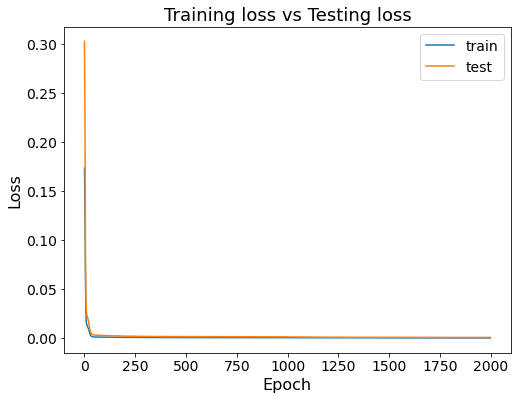

In [28]:
lr = 0.00001
EPOCHS = 2000
model_rnn_60.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

history = model_rnn_60.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=False)

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [50]:
# # Save the entire model as a SavedModel.
# !mkdir -p saved_model
model_rnn_60.save('saved_model/rnn_11')

INFO:tensorflow:Assets written to: saved_model/rnn_11/assets


In [29]:
# from keras.models import load_model

# model_load = load_model('saved_model/model_rnn_60')

### Prediction

#### Test set

In [29]:
yhat = model_rnn_60.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

602/602 [==============================] - 4s 6ms/step
inv_y.shape, inv_yhat.shape (19249, 96) (19249, 96)


In [30]:
# inv_y

In [31]:
# inv_yhat

In [32]:
error_abs = abs(inv_yhat - inv_y)
# error_abs

In [34]:
error = inv_yhat - inv_y
# error

In [35]:
## 17544 = 24 * (365+366)
error_19_20 = error.iloc[-17544:, :]

In [36]:
len(error_19_20)

17544

In [49]:
inv_y.to_csv('./output/inv_y_rnn_11.csv')
inv_yhat.to_csv('./output/inv_yhat_rnn_11.csv')
error.to_csv('output/error_rnn_11.csv')

### Performance

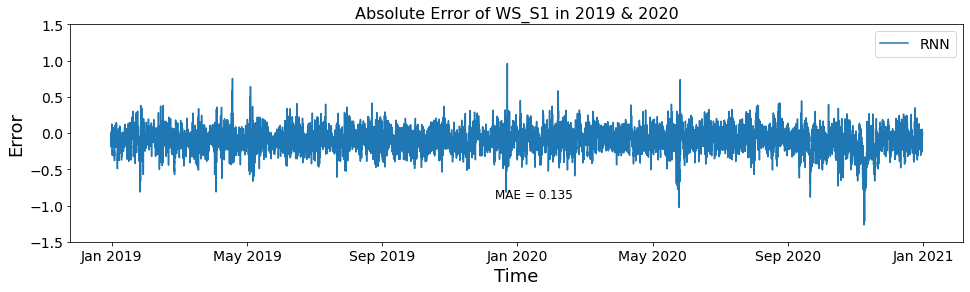

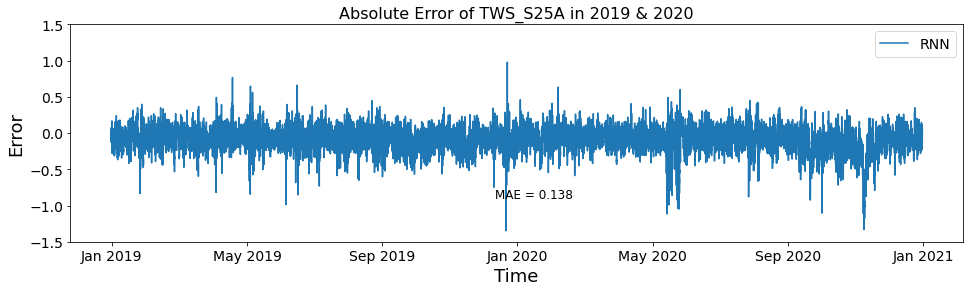

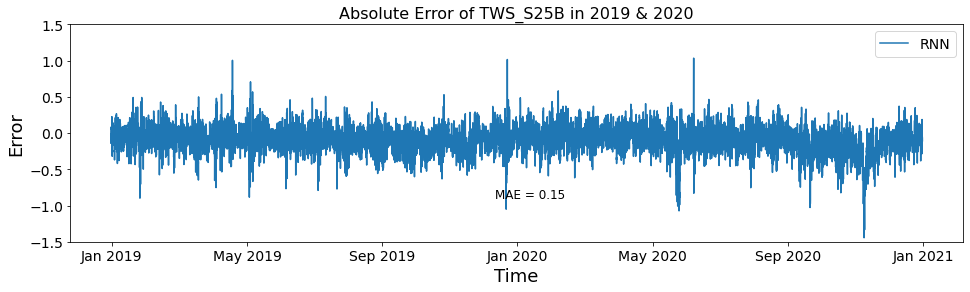

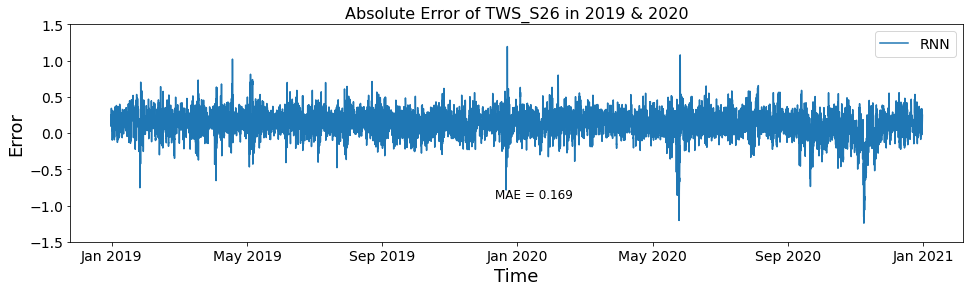

In [45]:
plt.rcParams["figure.figsize"] = (16, 4)
months = ['Jan 2019', 'May 2019', 'Sep 2019', 'Jan 2020', 'May 2020', 'Sep 2020', 'Jan 2021']

# 17544 = 24 hours * (365+366) days
locations = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
for i, col in enumerate([-4, -3, -2, -1]):
    plt.plot(error.iloc[-17544:, col], label='RNN')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Error', fontsize=18)
    plt.ylim(-1.5, 1.5)
    plt.xticks(np.arange(1726, 19270, 2923), months, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Absolute Error of {} in 2019 & 2020'.format(locations[i]), fontsize=16)
    # plt.savefig('figures/Test_Error_rnn_chop.png', dpi=300)
    plt.text(10000, -0.9, 'MAE = {}'.format(float("{:.3f}".format(sum(abs(error.iloc[-17544:, col]))/17544))), fontsize=12)
    plt.show()
    plt.close()

In [46]:
error_24th_hour = error.iloc[:, [-4, -3, -2, -1]]  # last 4 columns --> t+12
error_24th_hour

,92,93,94,95
0,-0.181153,-0.046961,-0.156345,0.146357
1,0.001384,0.117568,-0.020528,0.261284
2,-0.100966,-0.028544,0.001773,0.182873
3,-0.180836,-0.146536,-0.150729,0.077708
4,-0.231686,-0.220690,-0.233354,0.020541
...,...,...,...,...
19244,-0.045204,-0.157146,-0.130086,0.106253
19245,0.008541,-0.096138,-0.051790,0.160254
19246,-0.016983,-0.105769,-0.058408,0.108995
19247,0.013847,0.042913,-0.068407,0.237995


In [47]:
# error.rename(columns = {'11':'WS_S1', '23':'TWS_S25A', '35':'TWS_S25B', '47':'TWS_S26'}, inplace = True)

In [48]:
error_24th_hour.columns = ['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
error_24th_hour

,WS_S1,TWS_S25A,TWS_S25B,TWS_S26
0,-0.181153,-0.046961,-0.156345,0.146357
1,0.001384,0.117568,-0.020528,0.261284
2,-0.100966,-0.028544,0.001773,0.182873
3,-0.180836,-0.146536,-0.150729,0.077708
4,-0.231686,-0.220690,-0.233354,0.020541
...,...,...,...,...
19244,-0.045204,-0.157146,-0.130086,0.106253
19245,0.008541,-0.096138,-0.051790,0.160254
19246,-0.016983,-0.105769,-0.058408,0.108995
19247,0.013847,0.042913,-0.068407,0.237995


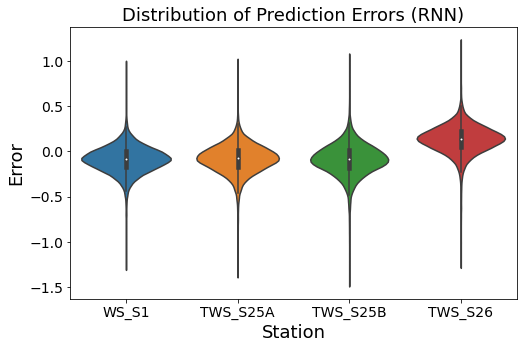

In [42]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 5)
# plt.grid()
plt.xlabel('Station', fontsize=18)
plt.ylabel('Error', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Distribution of Prediction Errors (RNN)', fontsize='18')
ax = sns.violinplot(data=error_24th_hour[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']])

In [122]:
# # Whole test set: WS = ['WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
# RMSES, MAES = [], []
# for i in range(inv_yhat.shape[1]):
#     RMSE = sqrt(mean_squared_error(inv_y.iloc[:, i], inv_yhat.iloc[:, i]))
#     MAE = mean_absolute_error(inv_y.iloc[:, i], inv_yhat.iloc[:, i])
#     RMSES.append(float("{:.4f}".format(RMSE)))
#     MAES.append(float("{:.4f}".format(MAE)))
    
# print("Test RMSE for WS_S1, TWS_S25A, TWS_S25B, TWS_S26:", RMSES)
# print("Test MAE for WS_S1, TWS_S25A, TWS_S25B, TWS_S26:", MAES)

In [123]:
# # Whole test set: WS = ['WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
# MAE, RMSE = [], []
# for row in range(len(inv_y)):
#     row_rmse, row_mae = [], []
#     for i in range(0, inv_y.shape[1], 12):
#         row_mae.append(float("{:.3f}".format(mean_absolute_error(inv_y.iloc[row, i:i+12], inv_yhat.iloc[row, i:i+12]))))
# #         row_rmse.append(float("{:.3f}".format(sqrt(mean_squared_error((inv_y.iloc[row, i:i+12], inv_yhat.iloc[row, i:i+12]))))))
#     MAE.append(np.array(row_mae))
# #     RMSE.append(np.array(row_rmse))

# print(np.array(MAE))
# # print(RMSE) 
# # print("Test RMSE for WS_S1, TWS_S25A, TWS_S25B, TWS_S26:", RMSES)
# # print("Test MAE for WS_S1, TWS_S25A, TWS_S25B, TWS_S26:", MAES)

In [124]:
# column_1 = []
# for row in np.array(MAE):
#     column_1.append(row[0])   

# print("1st column =", column_1)
# print(sum(column_1)/len(column_1))

In [125]:
# plt.hist(column_1)

In [126]:
# mean_absolute_error(inv_y.iloc[0, i:i+12], inv_yhat.iloc[0, i:i+12])

In [127]:
# # Whole test set: WS = ['WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
# RMSES, MAES = [], []
# for i in range(inv_yhat.shape[1]):
#     RMSE = sqrt(mean_squared_error(inv_y.iloc[:, i:i+12], inv_yhat.iloc[:, i:i+12]))
#     MAE = mean_absolute_error(inv_y.iloc[0, i:i+12], inv_yhat.iloc[0, i:i+12])
#     RMSES.append(float("{:.3f}".format(RMSE)))
#     MAES.append(float("{:.3f}".format(MAE)))
# print("Test RMSE for WS_S1, TWS_S25A, TWS_S25B, TWS_S26:", RMSES)
# print("Test MAE for WS_S1, TWS_S25A, TWS_S25B, TWS_S26:", MAES)


# # # 'WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26', 'HWS_S25A', 'HWS_S25B', 'HWS_S26'
# # plt.rcParams["figure.figsize"] = (8, 6)
# # plt.title('Comparison RMSE & MAE at Different Locations', fontsize=18)
# # plt.plot(RMSES, label='RMSE', marker='D')
# # plt.plot(MAES, label='MAE', marker='o')
# # plt.xlabel('Locations', fontsize=16)
# # plt.ylabel('Error', fontsize=16)
# # plt.xticks(np.arange(5), ['S1', 'S4', 'S25A', 'S25B', 'S26'], fontsize=14)
# # plt.yticks(fontsize=14)
# # # plt.axhline(y=0.15, color='red', linestyle='-', linewidth=2)
# # # plt.axhline(y=0.25, color='orange', linestyle='-', linewidth=2)
# # # plt.text(0, 0.26, 'R=0.25', fontsize=14)
# # # plt.text(0, 0.16, 'R=0.15', fontsize=14)
# # plt.legend(fontsize=14)
# # plt.show()

### Visualization

#### Visualize some period (09/10/2022 - 09/16/2022)

In [128]:
# date = ['09/10', '09/11', '09/12', '09/13', '09/14', '09/15', '09/16']
# station = ['WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
# for i in range(5):
#     rmse = sqrt(mean_squared_error(inv_y.iloc[:144, i], inv_yhat.iloc[:144, i]))    # 99635:100499
#     mae = mean_absolute_error(inv_y.iloc[:144, 0], inv_yhat.iloc[:144, 0])
#     plt.rcParams["figure.figsize"] = (8, 6)
#     plt.plot(inv_yhat.iloc[:144, i], label='prediction', linewidth=2)
#     plt.plot(inv_y.iloc[:144, i], label='truth', linewidth=2)
#     plt.title('Predicted & Actual Value of {}'.format(station[i]), fontsize=18)
#     # plt.text(99858, 3.35, 'MAE: {:.4f}'.format(MAE_WS_S1), fontsize=13)
#     plt.xlabel('Time', fontsize=16)
#     plt.ylabel('Water Stage', fontsize=16)
#     # plt.xticks(np.arange(99635, 100500, 144), date, fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.legend(fontsize=13, loc='upper left')
#     plt.show()
#     plt.close()

#### Visualize error values

In [129]:
# n_train_hours

In [41]:
# ['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 
# 'FLOW_S25B', 'GATE_S25B', 'HWS_S25B', 'TWS_S25B', 
# 'FLOW_S26', 'GATE_S26', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'mean']

In [130]:
# date = ['10/2018', '04/2019', '10/2019', '04/2019', '10/2020']
# # station = ['WS_S1', 'WS_S4', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']
# station = ['S1', 'S4', 'S25A', 'S25B', 'S26']

# plt.rcParams["figure.figsize"] = (16, 2)

# for i in range(5):
#     error = abs(inv_yhat.iloc[:, i] - inv_y.iloc[:, i])
#     plt.plot(error, label='{}'.format(station[i]), linewidth=2)

# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Abs Error', fontsize=16)
# plt.xticks(np.arange(0, len(inv_y), 4449), date, fontsize=14)  # len(inv_y) = 19238
# plt.yticks(fontsize=14)
# plt.legend(fontsize=10, loc='upper left')
# plt.show()
# plt.close()


# # visualize rain in test set
# plt.plot(data.iloc[76951:, -1])
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Rainfall (Inch)', fontsize=16)
# plt.xticks(np.arange(0, len(inv_y), 4449), date, fontsize=14)  # len(inv_y) = 19238
# plt.yticks(fontsize=14)
# plt.show()
# plt.close()


# # visualize pump in test set
# plt.plot(data.iloc[76951:, -2])
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Pump_S26', fontsize=16)
# plt.xticks(np.arange(0, len(inv_y), 4449), date, fontsize=14)  # len(inv_y) = 19238
# plt.yticks(fontsize=14)
# plt.show()
# plt.close()

# # visualize gate_s25a in test set
# plt.plot(data.iloc[76951:, 3])
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Gate_S25A', fontsize=16)
# plt.xticks(np.arange(0, len(inv_y), 4449), date, fontsize=14)  # len(inv_y) = 19238
# plt.yticks(fontsize=14)
# plt.show()
# plt.close()

# # visualize gate_s25b in test set
# plt.plot(data.iloc[76951:, 7])
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Gate_S26B', fontsize=16)
# plt.xticks(np.arange(0, len(inv_y), 4449), date, fontsize=14)  # len(inv_y) = 19238
# plt.yticks(fontsize=14)
# plt.show()
# plt.close()

# # visualize gate_s26 in test set
# plt.plot(data.iloc[76951:, 11])
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Gate_S26', fontsize=16)
# plt.xticks(np.arange(0, len(inv_y), 4449), date, fontsize=14)  # len(inv_y) = 19238
# plt.yticks(fontsize=14)
# plt.show()
# plt.close()

In [131]:
# # visualize water stage error seperately
# for i in range(5):
#     plt.rcParams["figure.figsize"] = (16, 2)
#     error = abs(inv_yhat.iloc[:, i] - inv_y.iloc[:, i])
#     plt.plot(error, label='{}'.format(station[i]), linewidth=2)
#     plt.xlabel('Time', fontsize=16)
#     plt.ylabel('Abs Error', fontsize=16)
#     plt.xticks(np.arange(0, len(inv_y), 4449), date, fontsize=14)  # len(inv_y) = 19238
#     plt.yticks(fontsize=14)
#     plt.legend(fontsize=12, loc='upper left')
#     plt.show()
#     plt.close()